# Configuration

## Time period

In [1]:
import pandas as pd

# Select start time of the analysis
START_TIME = pd.to_datetime("2010-06-01")

# Select the months of interest
START_MONTH = 1
END_MONTH = 12

# Select the measurement hours to consider.
DAILY_HOURS = "noon"
assert DAILY_HOURS in ["all", "noon"]

# Select years to use as test set (2010 and 2018 are the known stress periods)
TEST_YEARS = [2010, 2018, 2021]

## Aggregation

In [2]:
# Select the method for aggregating raw measurements to daily values.
DAILY_AGG_METHOD = "median"
assert DAILY_AGG_METHOD in ["mean", "median"]

# Set the window size and aggregation method for combining daily measurements
WINDOW_SIZE = 3
WINDOW_AGG_METHOD = "mean"
assert WINDOW_AGG_METHOD in ["mean", "median"]

# Window size for calculating standard deviation
STATS_WINDOW_SIZE = 14

## Features and target variables

In [3]:
# Select target variables to use.
TARGET_VARIABLES = ["monoterp", "sensible_heat", "latent_heat", "nee"]

# Verify the selected target variables
possible_target_variables = ["monoterp", "sensible_heat", "latent_heat", "nee"]
for x in TARGET_VARIABLES:
    assert x in possible_target_variables

# Select whether to impute or delete rows with missing values
IMPUTE = False

# Choose whether to use lagging variables and lag_size
USE_LAGS = False
LAG_SIZE = 5
LAG_COLUMNS = ["PAR_rm", "precip_rm", "t672_rm", "wpsoil_A_rm", "wsoil_B1_p50_rm"]

# Verify the selected lag columns
for col in LAG_COLUMNS:
    assert col in ["PAR_rm", "precip_rm", "t672_rm", "wpsoil_A_rm", "wsoil_B1_p50_rm"]

# Select whether to use the time of year as a feature
USE_TIME_OF_YEAR = False

# Select whether to use z-scores or absolute values of the driving variables
USE_Z_SCORES = True

# Use SMOTE to oversample the minority class
USE_SMOTE = False

## Stress

In [4]:
# Select stress stresholds to be used in classification
COMBINED_STRESS_THRESHOLD = 3.5
INDIVIDUAL_STRESS_THRESHOLD = 2

## Models

In [5]:
# Class weights for the tree based classifiers
CLASS_WEIGHTS = {0: 0.8, 1: 1.2}

# Max depth for the tree based classifiers
MAX_DEPTH = 4

# Select classification model results to visualize
MODEL = "dtc"
assert MODEL in ["rfc", "dtc", "logr", "lgbc"]

# Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
import lightgbm

# Read data

In [7]:
df1 = pd.read_csv("./data/GPP_NEE_flux_2001-2022.csv")
df2 = pd.read_csv("./data/voc_2010-2022.csv")
df3 = pd.read_csv("./data/latent_heat_flux_2018-2022.csv")
df4 = pd.read_csv("./data/latent_heat_flux_2001-2018.csv")
df5 = pd.read_csv("./data/sensible_heat_flux_2001-2022.csv")
df6 = pd.read_csv("./data/HYY_META.PAR_1997-01-01--9999-09-09.csv")
df7 = pd.read_csv("./data/HYY_META.Precipacc_2005-04-01--9999-09-09.csv")
df8 = pd.read_csv("./data/HYY_META.T672_1997-01-01--9999-09-09.csv")
df9 = pd.read_csv("./data/HYY_META.wpsoil_A_2005-06-17--9999-09-09.csv")
df10 = pd.read_csv("./data/HYY_META.wsoil_B1_p50_2007-02-01--2023-04-04.csv")

# Drop columnns 'Unnamed: 0'
df1 = df1.drop(columns=["Unnamed: 0"])
df2 = df2.drop(columns=["Unnamed: 0"])
df3 = df3.drop(columns=["Unnamed: 0"])
df4 = df4.drop(columns=["Unnamed: 0"])
df5 = df5.drop(columns=["Unnamed: 0"])
df6 = df6.drop(columns=["Unnamed: 0"])
df7 = df7.drop(columns=["Unnamed: 0"])
df8 = df8.drop(columns=["Unnamed: 0"])
df9 = df9.drop(columns=["Unnamed: 0"])
df10 = df10.drop(columns=["Unnamed: 0"])

# Convert time labels to datetime objects
df1["Datetime"] = pd.to_datetime(df1["Datetime"])
df2["Datetime"] = pd.to_datetime(df2["Datetime"])
df3["Datetime"] = pd.to_datetime(df3["Datetime"])
df4["Datetime"] = pd.to_datetime(df4["Datetime"])
df5["Datetime"] = pd.to_datetime(df5["Datetime"])
df6["Datetime"] = pd.to_datetime(df6["Datetime"])
df7["Datetime"] = pd.to_datetime(df7["Datetime"])
df8["Datetime"] = pd.to_datetime(df8["Datetime"])
df9["Datetime"] = pd.to_datetime(df9["Datetime"])
df10["Datetime"] = pd.to_datetime(df10["Datetime"])

# Prepare the data

In [8]:
if DAILY_HOURS == "noon":
    # keep only observations occurring during 10.00-14.00 each day
    df1 = df1[(df1["Datetime"].dt.hour >= 10) & (df1["Datetime"].dt.hour <= 14)]
    df2 = df2[(df2["Datetime"].dt.hour >= 10) & (df2["Datetime"].dt.hour <= 14)]
    df3 = df3[(df3["Datetime"].dt.hour >= 10) & (df3["Datetime"].dt.hour <= 14)]
    df4 = df4[(df4["Datetime"].dt.hour >= 10) & (df4["Datetime"].dt.hour <= 14)]
    df5 = df5[(df5["Datetime"].dt.hour >= 10) & (df5["Datetime"].dt.hour <= 14)]
    df6 = df6[(df6["Datetime"].dt.hour >= 10) & (df6["Datetime"].dt.hour <= 14)]
    df7 = df7[(df7["Datetime"].dt.hour >= 10) & (df7["Datetime"].dt.hour <= 14)]
    df8 = df8[(df8["Datetime"].dt.hour >= 10) & (df8["Datetime"].dt.hour <= 14)]
    df9 = df9[(df9["Datetime"].dt.hour >= 10) & (df9["Datetime"].dt.hour <= 14)]
    df10 = df10[(df10["Datetime"].dt.hour >= 10) & (df10["Datetime"].dt.hour <= 14)]

In [9]:
# Keep only the rows where NEE_gapfilling_method is 0
df1 = df1[df1.NEE_gapfilling_method == 0]

# Reset the index
df1.reset_index(drop=True, inplace=True)

In [10]:
# Aggregate to daily values
if DAILY_AGG_METHOD == "mean":
    daily_df1 = df1.resample("D", on="Datetime").mean().reset_index()
    daily_df2 = df2.resample("D", on="Datetime").mean().reset_index()
    daily_df3 = df3.resample("D", on="Datetime").mean().reset_index()
    daily_df4 = df4.resample("D", on="Datetime").mean().reset_index()
    daily_df5 = df5.resample("D", on="Datetime").mean().reset_index()
    daily_df6 = df6.resample("D", on="Datetime").mean().reset_index()
    daily_df7 = df7.resample("D", on="Datetime").mean().reset_index()
    daily_df8 = df8.resample("D", on="Datetime").mean().reset_index()
    daily_df9 = df9.resample("D", on="Datetime").mean().reset_index()
    daily_df10 = df10.resample("D", on="Datetime").mean().reset_index()
elif DAILY_AGG_METHOD == "median":
    daily_df1 = df1.resample("D", on="Datetime").median().reset_index()
    daily_df2 = df2.resample("D", on="Datetime").median().reset_index()
    daily_df3 = df3.resample("D", on="Datetime").median().reset_index()
    daily_df4 = df4.resample("D", on="Datetime").median().reset_index()
    daily_df5 = df5.resample("D", on="Datetime").median().reset_index()
    daily_df6 = df6.resample("D", on="Datetime").median().reset_index()
    daily_df7 = df7.resample("D", on="Datetime").median().reset_index()
    daily_df8 = df8.resample("D", on="Datetime").median().reset_index()
    daily_df9 = df9.resample("D", on="Datetime").median().reset_index()
    daily_df10 = df10.resample("D", on="Datetime").median().reset_index()
else:
    raise ValueError('agg_method must be either "mean" or "median"')

In [11]:
# Combine latent heat flux data from 2001-2018 and 2018-2022 to same dataframe: lh_df
daily_df4 = daily_df4.rename(columns={"HYY_EDDY233.LE": "lh_flux"})
daily_df4 = daily_df4.drop(columns=["HYY_EDDY233.Qc_LE"])

daily_df3 = daily_df3.rename(columns={"latent_heat_flux_after_4-2018": "lh_flux"})
daily_df3 = daily_df3.drop(columns=["latent_heat_flux_quality_flag_after_4-2018"])
lh_df = pd.concat([daily_df4, daily_df3], ignore_index=True)

In [12]:
# Drop unnecessary columns
daily_df1 = daily_df1.drop(columns=["NEE_gapfilling_method", "GPP"])
daily_df5 = daily_df5.drop(columns=["sensible_heat_flux_gapfilling_method"])
daily_df2 = daily_df2.drop(
    columns=["methanol_flux", "acetone_flux", "acetaldehyde_flux"]
)

In [13]:
# Merge all variables into one dataframe
ddf = pd.merge(daily_df1, daily_df2, on="Datetime", how="outer")
ddf = pd.merge(ddf, lh_df, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df5, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df6, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df7, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df8, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df9, on="Datetime", how="outer")
ddf = pd.merge(ddf, daily_df10, on="Datetime", how="outer")

In [14]:
# Keep only the measurements after start_time
ddf = ddf[ddf["Datetime"] >= START_TIME]

# Filter data between start_month and end_month
ddf = ddf[
    (ddf["Datetime"].dt.month >= START_MONTH) & (ddf["Datetime"].dt.month <= END_MONTH)
]  # .copy()

In [15]:
# Convert each daily value into a rolling value over the selected window size
if WINDOW_AGG_METHOD == "median":
    ddf["monoterp_rm"] = (
        ddf["monoterpene_flux"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["sensible_heat_rm"] = (
        ddf["sensible_heat_flux"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
    ddf["latent_heat_rm"] = (
        ddf["lh_flux"].rolling(window=WINDOW_SIZE, min_periods=1, center=False).median()
    )
    ddf["nee_rm"] = (
        ddf["NEE"].rolling(window=WINDOW_SIZE, min_periods=1, center=False).median()
    )
    ddf["PAR_rm"] = (
        ddf["HYY_META.PAR"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
    ddf["precip_rm"] = (
        ddf["HYY_META.Precipacc"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
    ddf["t672_rm"] = (
        ddf["HYY_META.T672"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
    ddf["wpsoil_A_rm"] = (
        ddf["HYY_META.wpsoil_A"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
    ddf["wsoil_B1_p50_rm"] = (
        ddf["HYY_META.wsoil_B1_p50"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .median()
    )
elif WINDOW_AGG_METHOD == "mean":
    ddf["monoterp_rm"] = (
        ddf["monoterpene_flux"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["sensible_heat_rm"] = (
        ddf["sensible_heat_flux"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["latent_heat_rm"] = (
        ddf["lh_flux"].rolling(window=WINDOW_SIZE, min_periods=1, center=False).mean()
    )
    ddf["nee_rm"] = (
        ddf["NEE"].rolling(window=WINDOW_SIZE, min_periods=1, center=False).mean()
    )
    ddf["PAR_rm"] = (
        ddf["HYY_META.PAR"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["precip_rm"] = (
        ddf["HYY_META.Precipacc"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["t672_rm"] = (
        ddf["HYY_META.T672"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["wpsoil_A_rm"] = (
        ddf["HYY_META.wpsoil_A"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )
    ddf["wsoil_B1_p50_rm"] = (
        ddf["HYY_META.wsoil_B1_p50"]
        .rolling(window=WINDOW_SIZE, min_periods=1, center=False)
        .mean()
    )

In [16]:
# Add a column for the day of year
ddf["day"] = ddf["Datetime"].dt.dayofyear

# Add a column for the year
ddf["year"] = ddf["Datetime"].dt.year

In [17]:
ddf.drop(
    columns=[
        "NEE",
        "monoterpene_flux",
        "lh_flux",
        "sensible_heat_flux",
        "HYY_META.PAR",
        "HYY_META.Precipacc",
        "HYY_META.T672",
        "HYY_META.wpsoil_A",
        "HYY_META.wsoil_B1_p50",
    ],
    inplace=True,
)

# Calculate z-scores

In [18]:
# Pivot the DataFrame so that rows are days and columns are years
df_mono = ddf.pivot(index="day", columns="year", values="monoterp_rm")
df_sensible = ddf.pivot(index="day", columns="year", values="sensible_heat_rm")
df_latent = ddf.pivot(index="day", columns="year", values="latent_heat_rm")
df_nee = ddf.pivot(index="day", columns="year", values="nee_rm")
df_PAR = ddf.pivot(index="day", columns="year", values="PAR_rm")
df_precip = ddf.pivot(index="day", columns="year", values="precip_rm")
df_t672 = ddf.pivot(index="day", columns="year", values="t672_rm")
df_wpsoil_A = ddf.pivot(index="day", columns="year", values="wpsoil_A_rm")
df_wsoil_B1_p50 = ddf.pivot(index="day", columns="year", values="wsoil_B1_p50_rm")

# Drop column year from ddf
ddf.drop(columns=["year"], inplace=True)

In [19]:
# Calculate rolling average and standard deviation for each variable


def rolling_stats(df, window_size):
    df["rolling_mean"] = np.nan
    df["rolling_std"] = np.nan

    for i in range(1, len(df) + 1):
        start = max(i - window_size // 2, 0)
        stop = min(i + window_size // 2, len(df))
        values = df.iloc[start:stop, :].values.flatten().tolist()
        filtered = [x for x in values if not math.isnan(x)]
        filtered = np.array(filtered)
        df.loc[i, "rolling_std"] = filtered.std(ddof=1)
        df.loc[i, "rolling_mean"] = filtered.mean()

    return df


df_mono = rolling_stats(df_mono, STATS_WINDOW_SIZE)
df_sensible = rolling_stats(df_sensible, STATS_WINDOW_SIZE)
df_latent = rolling_stats(df_latent, STATS_WINDOW_SIZE)
df_nee = rolling_stats(df_nee, STATS_WINDOW_SIZE)
df_PAR = rolling_stats(df_PAR, STATS_WINDOW_SIZE)
df_precip = rolling_stats(df_precip, STATS_WINDOW_SIZE)
df_t672 = rolling_stats(df_t672, STATS_WINDOW_SIZE)
df_wpsoil_A = rolling_stats(df_wpsoil_A, STATS_WINDOW_SIZE)
df_wsoil_B1_p50 = rolling_stats(df_wsoil_B1_p50, WINDOW_SIZE)

In [20]:
# Create a new dataframe for z-scores as a copy of ddf
z_scores = ddf.copy()
z_scores.set_index("Datetime", inplace=True)

# calculate z-scores for each variable
for index, row in z_scores.iterrows():
    day = index.dayofyear

    z_scores.at[index, "monoterp_zscore"] = (
        row["monoterp_rm"] - df_mono.loc[day, "rolling_mean"]
    ) / df_mono.loc[day, "rolling_std"]

    z_scores.at[index, "sensible_heat_zscore"] = (
        row["sensible_heat_rm"] - df_sensible.loc[day, "rolling_mean"]
    ) / df_sensible.loc[day, "rolling_std"]

    z_scores.at[index, "latent_heat_zscore"] = (
        row["latent_heat_rm"] - df_latent.loc[day, "rolling_mean"]
    ) / df_latent.loc[day, "rolling_std"]

    z_scores.at[index, "nee_zscore"] = (
        row["nee_rm"] - df_nee.loc[day, "rolling_mean"]
    ) / df_nee.loc[day, "rolling_std"]

    z_scores.at[index, "PAR_zscore"] = (
        row["PAR_rm"] - df_PAR.loc[day, "rolling_mean"]
    ) / df_PAR.loc[day, "rolling_std"]

    z_scores.at[index, "precip_zscore"] = (
        row["precip_rm"] - df_precip.loc[day, "rolling_mean"]
    ) / df_precip.loc[day, "rolling_std"]

    z_scores.at[index, "t672_zscore"] = (
        row["t672_rm"] - df_t672.loc[day, "rolling_mean"]
    ) / df_t672.loc[day, "rolling_std"]

    z_scores.at[index, "wpsoil_A_zscore"] = (
        row["wpsoil_A_rm"] - df_wpsoil_A.loc[day, "rolling_mean"]
    ) / df_wpsoil_A.loc[day, "rolling_std"]

    z_scores.at[index, "wsoil_B1_p50_zscore"] = (
        row["wsoil_B1_p50_rm"] - df_wsoil_B1_p50.loc[day, "rolling_mean"]
    ) / df_wsoil_B1_p50.loc[day, "rolling_std"]


z_scores.drop(
    columns=[
        "monoterp_rm",
        "sensible_heat_rm",
        "latent_heat_rm",
        "nee_rm",
        "PAR_rm",
        "precip_rm",
        "t672_rm",
        "wpsoil_A_rm",
        "wsoil_B1_p50_rm",
    ],
    inplace=True,
)

if IMPUTE:
    # Replace NaN with 0, that is, assume that missing values are normal
    z_scores.fillna(0, inplace=True)

z_scores_2010 = z_scores[z_scores.index.year == 2010]
z_scores_2011 = z_scores[z_scores.index.year == 2011]
z_scores_2012 = z_scores[z_scores.index.year == 2012]
z_scores_2013 = z_scores[z_scores.index.year == 2013]
z_scores_2014 = z_scores[z_scores.index.year == 2014]
z_scores_2015 = z_scores[z_scores.index.year == 2015]
z_scores_2016 = z_scores[z_scores.index.year == 2016]
z_scores_2017 = z_scores[z_scores.index.year == 2017]
z_scores_2018 = z_scores[z_scores.index.year == 2018]
z_scores_2019 = z_scores[z_scores.index.year == 2019]
z_scores_2020 = z_scores[z_scores.index.year == 2020]
z_scores_2021 = z_scores[z_scores.index.year == 2021]
z_scores_2022 = z_scores[z_scores.index.year == 2022]

z_scores_2010.set_index("day", inplace=True)
z_scores_2011.set_index("day", inplace=True)
z_scores_2012.set_index("day", inplace=True)
z_scores_2013.set_index("day", inplace=True)
z_scores_2014.set_index("day", inplace=True)
z_scores_2015.set_index("day", inplace=True)
z_scores_2016.set_index("day", inplace=True)
z_scores_2017.set_index("day", inplace=True)
z_scores_2018.set_index("day", inplace=True)
z_scores_2019.set_index("day", inplace=True)
z_scores_2020.set_index("day", inplace=True)
z_scores_2021.set_index("day", inplace=True)
z_scores_2022.set_index("day", inplace=True)

# Feature engineering and selection

In [21]:
# Take a copy of ddf in order to be able to run the code from this point without running the previous cells
ddf2 = ddf.copy()

# If ddf2 has a column named 'level_0' drop it
if "level_0" in z_scores.columns:
    z_scores.drop(columns=["level_0"], inplace=True)

# If z_scores has an index, reset it
if z_scores.index is not None:
    z_scores.reset_index(inplace=True)

# Merge the dataframes
ddf2 = ddf2.merge(z_scores, on="Datetime", how="inner")

# Rename column 'day_x' to 'day'
ddf2.rename(columns={"day_x": "day"}, inplace=True)

# Convert day number to circular coordinates
if USE_TIME_OF_YEAR:

    def day_to_coordinates(day_number):
        normalized_day = day_number / 365.0
        angle = normalized_day * 2 * math.pi
        x = np.sin(angle)
        y = np.cos(angle)
        return x, y

    # Apply the function
    ddf2[["x_coord", "y_coord"]] = ddf2["day"].apply(
        lambda x: pd.Series(day_to_coordinates(x))
    )

    # Move the x and y columns to the front of the DataFrame
    ddf2 = ddf2[
        ["x_coord", "y_coord"]
        + [col for col in ddf2.columns if col not in ["x_coord", "y_coord"]]
    ]

# Create lags
if USE_LAGS:
    # Calculate lagging variables for specified columns
    lag_df = ddf2[LAG_COLUMNS].rolling(window=LAG_SIZE).mean().shift(1)

    # Rename the columns with lag suffix
    lag_df.columns = [col + "_lag" + str(LAG_SIZE) for col in lag_df.columns]

    # Concatenate the original DataFrame with lagging variables
    ddf2 = pd.concat([ddf2, lag_df], axis=1)


# Use either absolute values or z-scores
if USE_Z_SCORES:
    ddf2.drop(
        columns=[
            "PAR_rm",
            "precip_rm",
            "t672_rm",
            "wpsoil_A_rm",
            "wsoil_B1_p50_rm",
        ],
        inplace=True,
    )
else:
    ddf2.drop(
        columns=[
            "PAR_zscore",
            "precip_zscore",
            "t672_zscore",
            "wpsoil_A_zscore",
            "wsoil_B1_p50_zscore",
        ],
        inplace=True,
    )

# If ddf2 has a column named 'level_0' or index, drop them as well.
if "level_0" in ddf2.columns:
    ddf2.drop(columns=["level_0"], inplace=True)
if "index" in ddf2.columns:
    ddf2.drop(columns=["index"], inplace=True)

# Drop columns that are not needed
ddf2.drop(
    columns=[
        "day",
        "monoterp_rm",
        "sensible_heat_rm",
        "latent_heat_rm",
        "latent_heat_rm",
        "nee_rm",
        "day_y",
    ],
    inplace=True,
)

# If column name in ddf2 included in dropped_target_variables, drop it.
dropped_target_variables = list(set(possible_target_variables) - set(TARGET_VARIABLES))
for x in dropped_target_variables:
    ddf2.drop(columns=[col for col in ddf2.columns if col.startswith(x)], inplace=True)

# Drop missing rows if impute is False
if not IMPUTE:
    ddf2.dropna(inplace=True)

# Add new column z_score as sum of the absolute values of the chosen TARGET_VARIABLES.
ddf2["z_score"] = 0
ddf2["individual_stress"] = 0
ddf2["combined_stress"] = 0
ddf2["stress"] = 0

# Calculate z-score and check for individual stress
for column in ddf2.columns:
    column_parts = column.split("_zscore")
    if len(column_parts) == 2 and column_parts[0] in TARGET_VARIABLES:
        ddf2.loc[
            ddf2[column].abs() > INDIVIDUAL_STRESS_THRESHOLD, "individual_stress"
        ] = 1
        ddf2["z_score"] += ddf2[column].abs()

# Check for combined stress
ddf2.loc[ddf2["z_score"].abs() > COMBINED_STRESS_THRESHOLD, "combined_stress"] = 1
ddf2.loc[
    (ddf2["combined_stress"] == 1) | (ddf2["individual_stress"] == 1), "stress"
] = 1

# Drop columns individual_stress and combined_stress
ddf2.drop(columns=["individual_stress", "combined_stress"], inplace=True)

# Take a copy for visualization purposes where the individual stress scores are kept
vis = ddf2.copy()

# Drop individual stress scores from the features, as they are not used by the models.
for column in ddf2.columns:
    column_parts = column.split("_zscore")
    if len(column_parts) == 2 and column_parts[0] in TARGET_VARIABLES:
        ddf2.drop(columns=[column], inplace=True)

# Verify the outcome
ddf2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2281 entries, 0 to 4597
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime             2281 non-null   datetime64[ns]
 1   PAR_zscore           2281 non-null   float64       
 2   precip_zscore        2281 non-null   float64       
 3   t672_zscore          2281 non-null   float64       
 4   wpsoil_A_zscore      2281 non-null   float64       
 5   wsoil_B1_p50_zscore  2281 non-null   float64       
 6   z_score              2281 non-null   float64       
 7   stress               2281 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 160.4 KB


# Train-test split

In [22]:
# Select test years

test = ddf2[ddf2.Datetime.dt.year.isin(TEST_YEARS)].copy()

train = ddf2[~ddf2.Datetime.dt.year.isin(TEST_YEARS)].copy()

# Drop the DateTime column from the DataFrames
train.drop(columns=["Datetime"], inplace=True)
test.drop(columns=["Datetime"], inplace=True)

# Shuffle the training data
train = train.sample(frac=1).reset_index(drop=True)

# Split the DataFrames into features (X) and target variable (y)
X_train_reg = train.drop(columns=["z_score", "stress"])
X_train_class = train.drop(columns=["z_score", "stress"])

y_train_reg = train["z_score"]
y_train_class = train["stress"]

X_test_reg = test.drop(columns=["z_score", "stress"])
X_test_class = test.drop(columns=["z_score", "stress"])

y_test_reg = test["z_score"]
y_test_class = test["stress"]

# Use SMOTE to balance the classification training set
if USE_SMOTE:
    sm = SMOTE(random_state=42)
    X_train_class, y_train_class = sm.fit_resample(X_train_class, y_train_class)

# Print the shapes of the resulting sets
print("X_train_reg shape:", X_train_reg.shape)
print("y_train_reg shape:", y_train_reg.shape)
print("")
print("X_test_reg shape:", X_test_reg.shape)
print("y_test_reg shape:", y_test_reg.shape)
print("")
print("X_train_class shape:", X_train_class.shape)
print("y_train_class shape:", y_train_class.shape)
print("")
print("X_test_class shape:", X_test_class.shape)
print("y_test_class shape:", y_test_class.shape)
print("")
print(
    "Share of stress events in the test set:",
    round(y_test_class.sum() / len(y_test_class), 2),
)
print(
    "Share of stress events in the training set:",
    round(y_train_class.sum() / len(y_train_class), 2),
)

X_train_reg shape: (1685, 5)
y_train_reg shape: (1685,)

X_test_reg shape: (596, 5)
y_test_reg shape: (596,)

X_train_class shape: (1685, 5)
y_train_class shape: (1685,)

X_test_class shape: (596, 5)
y_test_class shape: (596,)

Share of stress events in the test set: 0.35
Share of stress events in the training set: 0.27


# Regression

## Random forest

In [23]:
# Fit the model
rfr = RandomForestRegressor(max_depth=MAX_DEPTH).fit(X_train_reg, y_train_reg)

# R2 score for train set
print("Train R2:", rfr.score(X_train_reg, y_train_reg))

# R2 score for test set
print("Test R2:", rfr.score(X_test_reg, y_test_reg))

Train R2: 0.25801255906003606
Test R2: 0.1391892373274678


## Decision tree

In [24]:
# Fit the model
dtr = tree.DecisionTreeRegressor(max_depth=MAX_DEPTH).fit(X_train_reg, y_train_reg)

# R2 score for train set
print("Train R2:", dtr.score(X_train_reg, y_train_reg))

# R2 score for test set
print("Test R2:", dtr.score(X_test_reg, y_test_reg))

Train R2: 0.22247114954263136
Test R2: 0.06539529186951609


## Linear regression

In [25]:
# Fit the model
lr = LinearRegression().fit(X_train_reg, y_train_reg)

# R2 score for train set
print("Train R2:", lr.score(X_train_reg, y_train_reg))

# R2 score for test set
print("Test R2:", lr.score(X_test_reg, y_test_reg))

Train R2: 0.012743643081151612
Test R2: 0.010878432032540686


## LGBM

In [26]:
# Fit the model
lgbr = lightgbm.LGBMRegressor(
    max_depth=MAX_DEPTH,
    verbose=-1,
).fit(X_train_reg, y_train_reg)

# R2 score for train set
print("Train R2:", lgbr.score(X_train_reg, y_train_reg))

# R2 score for test set
print("Test R2:", lgbr.score(X_test_reg, y_test_reg))

Train R2: 0.47797512269836173
Test R2: 0.11826280476205098


# Classification

## Random forest

In [27]:
# Create and fit the model
rfc = RandomForestClassifier(
    class_weight=CLASS_WEIGHTS,
    max_depth=MAX_DEPTH,
    criterion="entropy",
).fit(X_train_class, y_train_class)

# Predict with train set
y_pred_train = rfc.predict(X_train_class)

# Predict with test set
y_pred_test = rfc.predict(X_test_class)

# Calculate train accuracy
accuracy = (y_pred_train == y_train_class).mean()
print("Train accuracy:", round(accuracy, 2))

# Calculate test accuracy
accuracy_rfc = (y_pred_test == y_test_class).mean()
print("Test accuracy:", round(accuracy_rfc, 2))
print("-----")

# Calculate train F1 score
f1 = f1_score(y_train_class, y_pred_train)
print("Train F1:", round(f1, 2))

# Calculate test F1 score
f1_rfc = f1_score(y_test_class, y_pred_test)
print("Test F1:", round(f1_rfc, 2))

Train accuracy: 0.79
Test accuracy: 0.7
-----
Train F1: 0.46
Test F1: 0.47


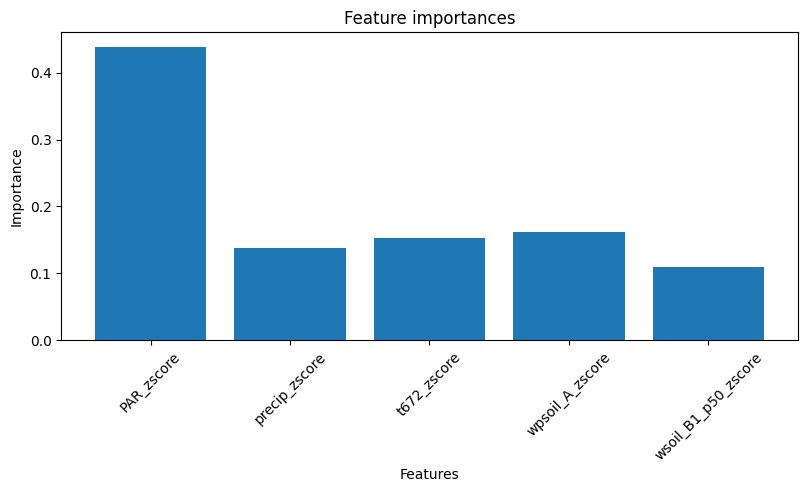

In [28]:
# Plot feature importances
plt.figure(figsize=(9.5, 4))
plt.bar(X_train_class.columns, rfc.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.xticks(rotation=45)
plt.show()

## Decision tree

In [29]:
# Create and fit the model
dtc = DecisionTreeClassifier(
    max_depth=MAX_DEPTH, criterion="entropy", class_weight=CLASS_WEIGHTS
).fit(X_train_class, y_train_class)

# Predict with train set
y_pred_train = dtc.predict(X_train_class)

# Predict with test set
y_pred_test = dtc.predict(X_test_class)

# Calculate train accuracy
accuracy = (y_pred_train == y_train_class).mean()
print("Train accuracy:", round(accuracy, 2))

# Calculate test accuracy
accuracy_dtc = (y_pred_test == y_test_class).mean()
print("Test accuracy:", round(accuracy_dtc, 2))
print("-----")

# Calculate train F1 score
f1 = f1_score(y_train_class, y_pred_train)
print("Train F1:", round(f1, 2))

# Calculate test F1 score
f1_dtc = f1_score(y_test_class, y_pred_test)
print("Test F1:", round(f1_dtc, 2))

Train accuracy: 0.76
Test accuracy: 0.66
-----
Train F1: 0.48
Test F1: 0.49


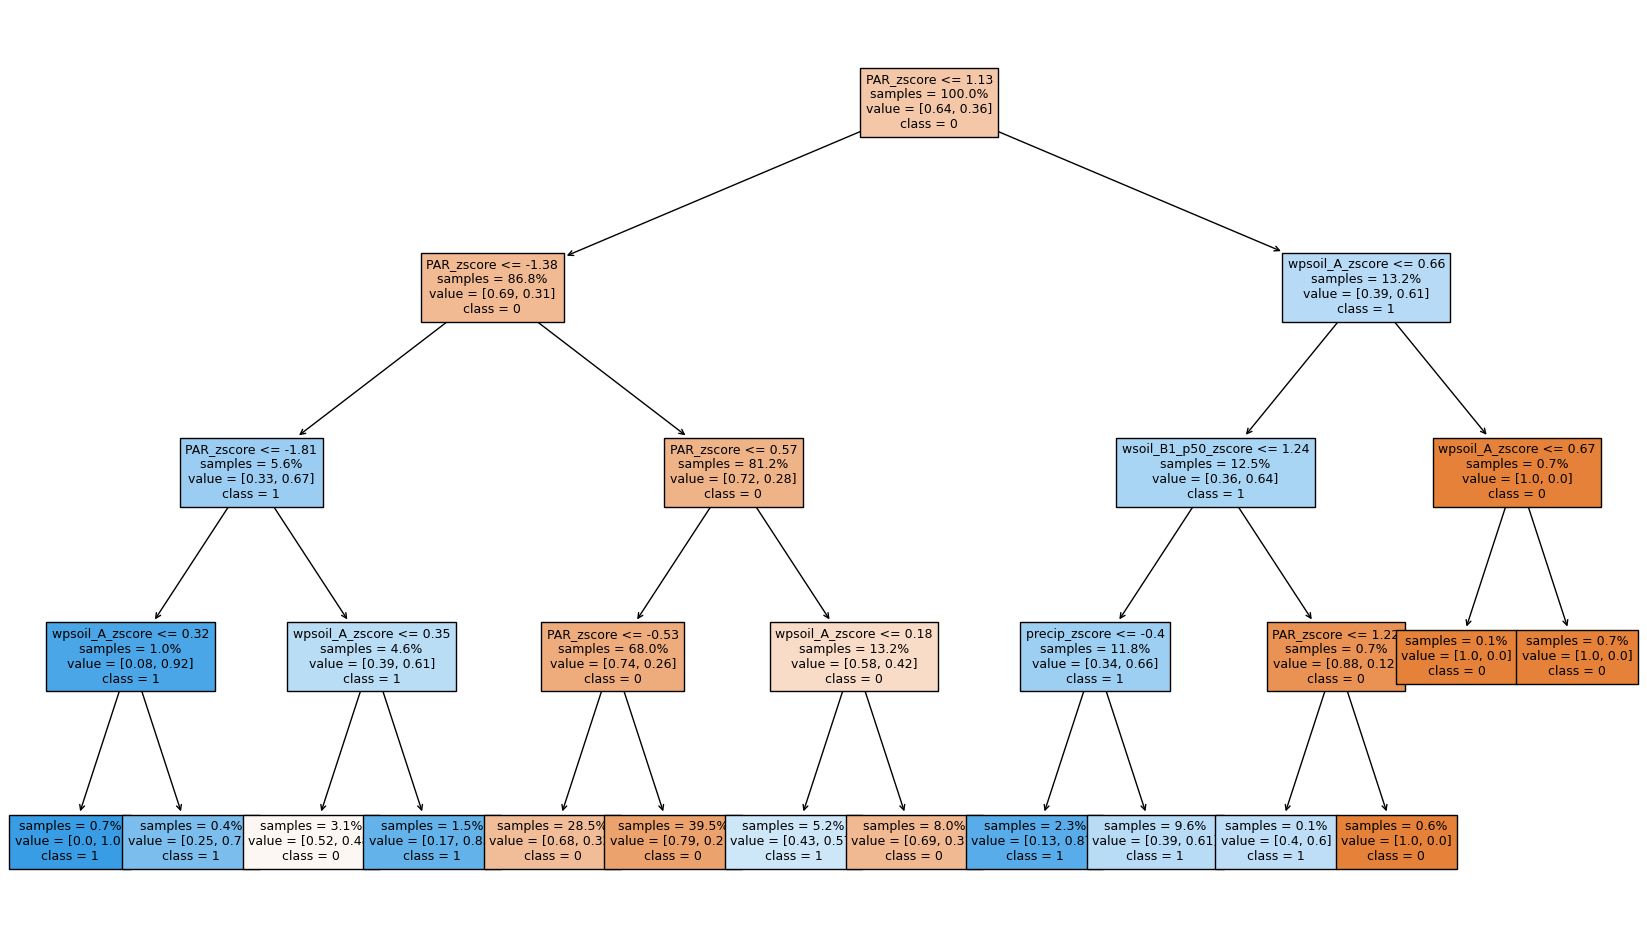

In [30]:
from sklearn.tree import plot_tree

# Visualize the decision tree
plt.figure(figsize=(21, 12))
plot_tree(
    dtc,
    filled=True,
    precision=2,
    label="all",
    impurity=False,
    class_names=["0", "1"],
    fontsize=9,
    proportion=True,
    feature_names=X_train_class.columns.to_list(),
)
plt.show()

In [31]:
dtc_text = tree.export_text(
    dtc, show_weights=False, feature_names=X_train_class.columns.to_list()
)
print(dtc_text)

|--- PAR_zscore <= 1.13
|   |--- PAR_zscore <= -1.38
|   |   |--- PAR_zscore <= -1.81
|   |   |   |--- wpsoil_A_zscore <= 0.32
|   |   |   |   |--- class: 1
|   |   |   |--- wpsoil_A_zscore >  0.32
|   |   |   |   |--- class: 1
|   |   |--- PAR_zscore >  -1.81
|   |   |   |--- wpsoil_A_zscore <= 0.35
|   |   |   |   |--- class: 0
|   |   |   |--- wpsoil_A_zscore >  0.35
|   |   |   |   |--- class: 1
|   |--- PAR_zscore >  -1.38
|   |   |--- PAR_zscore <= 0.57
|   |   |   |--- PAR_zscore <= -0.53
|   |   |   |   |--- class: 0
|   |   |   |--- PAR_zscore >  -0.53
|   |   |   |   |--- class: 0
|   |   |--- PAR_zscore >  0.57
|   |   |   |--- wpsoil_A_zscore <= 0.18
|   |   |   |   |--- class: 1
|   |   |   |--- wpsoil_A_zscore >  0.18
|   |   |   |   |--- class: 0
|--- PAR_zscore >  1.13
|   |--- wpsoil_A_zscore <= 0.66
|   |   |--- wsoil_B1_p50_zscore <= 1.24
|   |   |   |--- precip_zscore <= -0.40
|   |   |   |   |--- class: 1
|   |   |   |--- precip_zscore >  -0.40
|   |   |   |   |---

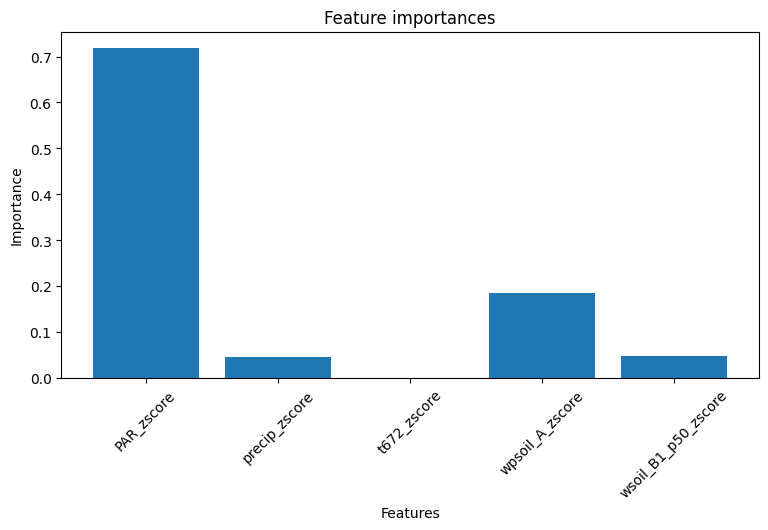

In [32]:
# Plot feature importances
plt.figure(figsize=(9, 4.5))
plt.bar(X_train_class.columns, dtc.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.xticks(rotation=45)
plt.show()

## Logistic regression

In [33]:
# Create and fit the model
logr = LogisticRegression().fit(X_train_class, y_train_class)

# Predict with train set
y_pred_train = logr.predict(X_train_class)

# Predict with test set
y_pred_test = logr.predict(X_test_class)

# Calculate train accuracy
accuracy = (y_pred_train == y_train_class).mean()
print("Train accuracy:", round(accuracy, 2))

# Calculate test accuracy
accuracy_logr = (y_pred_test == y_test_class).mean()
print("Test accuracy:", round(accuracy_logr, 2))
print("-----")

# Calculate train F1 score
f1 = f1_score(y_train_class, y_pred_train)
print("Train F1:", round(f1, 2))

# Calculate test F1 score
f1_logr = f1_score(y_test_class, y_pred_test)
print("Test F1:", round(f1_logr, 2))

Train accuracy: 0.73
Test accuracy: 0.65
-----
Train F1: 0.0
Test F1: 0.02


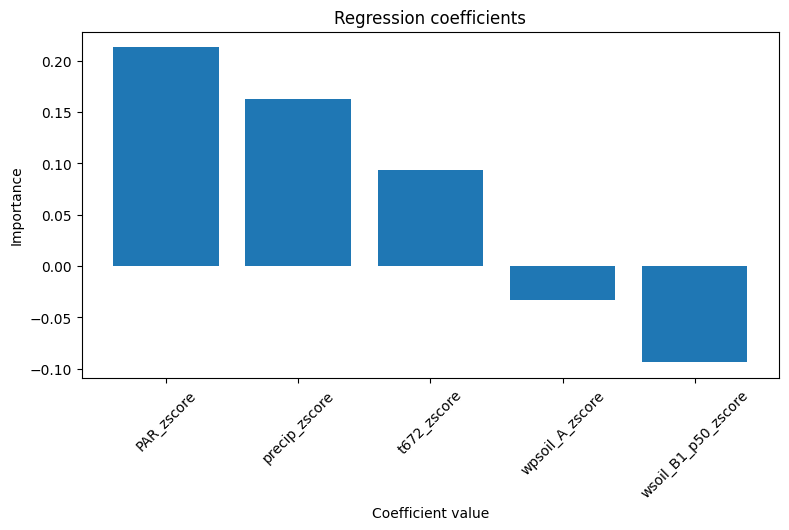

In [34]:
# Plot regression coefficients
plt.figure(figsize=(9, 4.5))
plt.bar(X_train_class.columns, logr.coef_.flatten())
plt.xlabel("Coefficient value")
plt.ylabel("Importance")
plt.title("Regression coefficients")
plt.xticks(rotation=45)
plt.show()

In [35]:
logr.coef_

array([[ 0.21325701,  0.1629924 ,  0.0935495 , -0.03310855, -0.09371251]])

## LGBM

In [36]:
# Create and fit the model
lgbc = lightgbm.LGBMClassifier(
    max_depth=MAX_DEPTH,
    criterion="entropy",
    class_weight=CLASS_WEIGHTS,
    verbose=-1,
).fit(X_train_class, y_train_class)

# Predict with train set
y_pred_train = lgbc.predict(X_train_class)

# Predict with test set
y_pred_test = lgbc.predict(X_test_class)

# Calculate train accuracy
accuracy = (y_pred_train == y_train_class).mean()
print("Train accuracy:", round(accuracy, 2))

# Calculate test accuracy
accuracy_lgbc = (y_pred_test == y_test_class).mean()
print("Test accuracy:", round(accuracy_lgbc, 2))
print("-----")

# Calculate train F1 score
f1 = f1_score(y_train_class, y_pred_train)
print("Train F1:", round(f1, 2))

# Calculate test F1 score
f1_lgbc = f1_score(y_test_class, y_pred_test)
print("Test F1:", round(f1_lgbc, 2))

Train accuracy: 0.87
Test accuracy: 0.69
-----
Train F1: 0.74
Test F1: 0.51


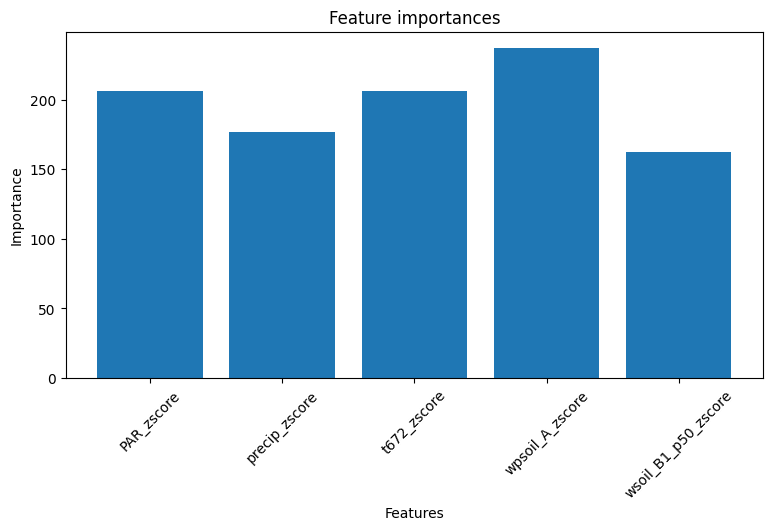

In [37]:
# Plot feature importances
plt.figure(figsize=(9, 4.5))
plt.bar(X_train_class.columns, lgbc.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.xticks(rotation=45)
plt.show()

## Visualization

In [38]:
if MODEL == "rfc":
    MODEL = rfc
    test_accuracy = round(accuracy_rfc, 2)
    test_f1 = round(f1_rfc, 2)
    model_name = "Random Forest Classifier"
elif MODEL == "dtc":
    MODEL = dtc
    test_accuracy = round(accuracy_dtc, 2)
    test_f1 = round(f1_dtc, 2)
    model_name = "Decision Tree Classifier"
elif MODEL == "logr":
    MODEL = logr
    test_accuracy = round(accuracy_logr, 2)
    test_f1 = round(f1_logr, 2)
    model_name = "Logistic Regression"
elif MODEL == "lgbc":
    MODEL = lgbc
    test_accuracy = round(accuracy_lgbc, 2)
    test_f1 = round(f1_lgbc, 2)
    model_name = "LightGBM Classifier"

In [39]:
def plot_year(year):
    try: 
        # Filter data for the given year
        vis_year = vis[vis["Datetime"].dt.year == year]
        X_year = ddf2[ddf2["Datetime"].dt.year == year]

        # Reset the indexes
        vis_year.reset_index(drop=True, inplace=True)
        X_year.reset_index(drop=True, inplace=True)

        # Create the plot
        aux = [x + "_zscore" for x in TARGET_VARIABLES]
        ax = vis_year[aux].plot(kind="bar", stacked=True, figsize=(20, 8))
    except IndexError:
        print(f"No data for {year}")
        return None
    
    # Plot z_score
    plt.plot(
        vis_year["z_score"], "k-", label="Combined z-score", linewidth=3, alpha=0.4
    )

    # Add markers for actual and predicted stress periods
    for i in range(len(X_year)):
        if X_year["stress"].iloc[i] == 1:
            plt.plot(i, COMBINED_STRESS_THRESHOLD + 0.1, "bo", markersize=7)
        if MODEL.predict(X_year[X_train_class.columns])[i] == 1:
            plt.plot(i, COMBINED_STRESS_THRESHOLD - 0.1, "ro", markersize=7)

    # Add legend
    plt.plot([], [], "bo", markersize=7, label="Actual stress")
    plt.plot([], [], "ro", markersize=7, label="Predicted stress")
    plt.legend()

    # Add text box with information
    plt.text(
        5,
        vis_year[aux].where(vis_year[aux] < 0).sum(axis=1).min(),
        f"""Model: {model_name}\n\
Features: {X_train_class.columns.tolist()}\n\
Combined stress threshold: {COMBINED_STRESS_THRESHOLD} std\n\
Individual stress threshold: {INDIVIDUAL_STRESS_THRESHOLD} std\n\
Test accuracy (2010, 2018, 2021): {test_accuracy}\n\
Test F1-score (2010, 2018, 2021): {test_f1}\n\
Missing values: {'Imputed' if IMPUTE else 'Dropped'}\n\
Oversampling: {'SMOTE' if USE_SMOTE else 'None'}\n\
Class weights: {CLASS_WEIGHTS}""",
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    # Customize plot appearance
    plt.gcf().set_size_inches(16, 9)
    ticks = list(range(1, len(vis_year.Datetime.dt.dayofyear) + 1, 5))
    plt.xticks(
        ticks, labels=np.array(vis_year.Datetime.dt.dayofyear + 1)[np.array(ticks) - 1]
    )
    plt.title(f"Stress predictions {year}")
    plt.xlabel("Day of year")
    plt.ylabel("Z scores")
    plt.axhline(0, color="black", linewidth=0.5)  # Highlight x-axis
    plt.show()

# Plot test years

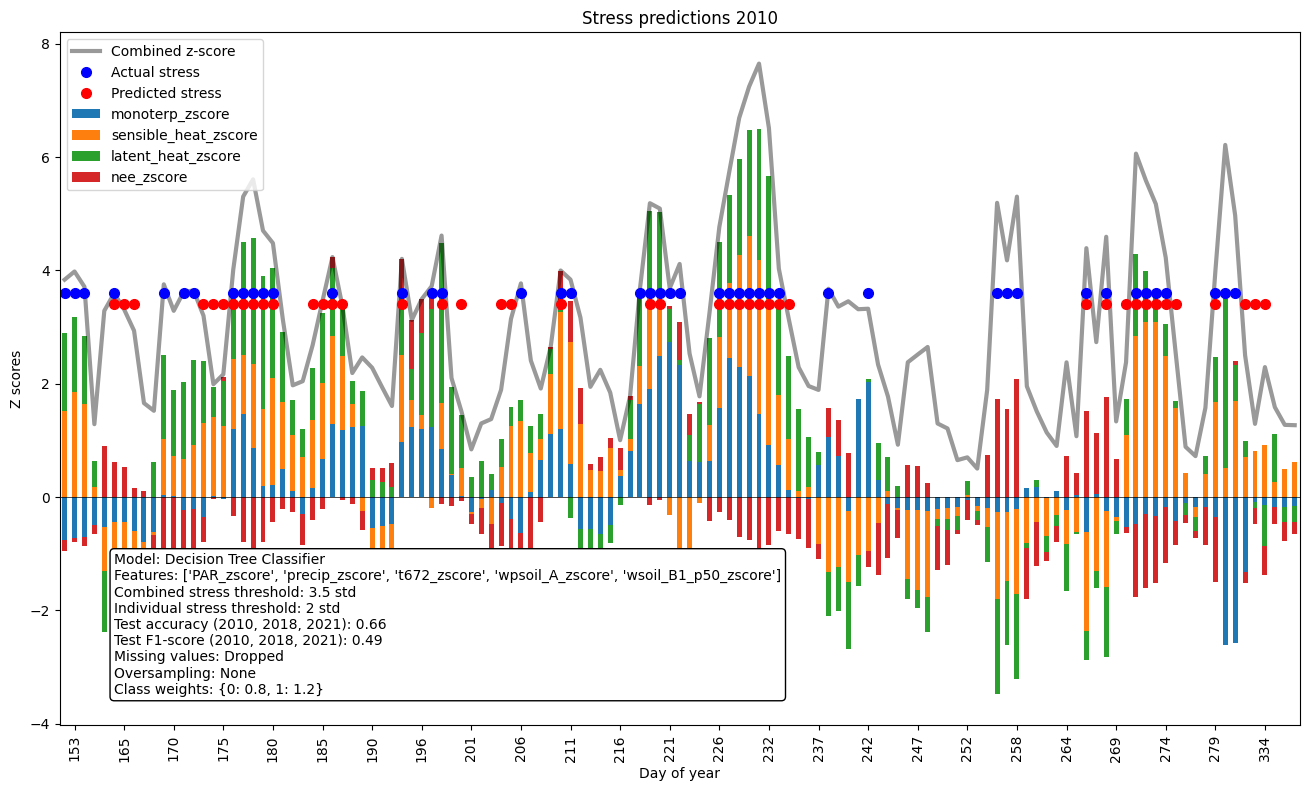

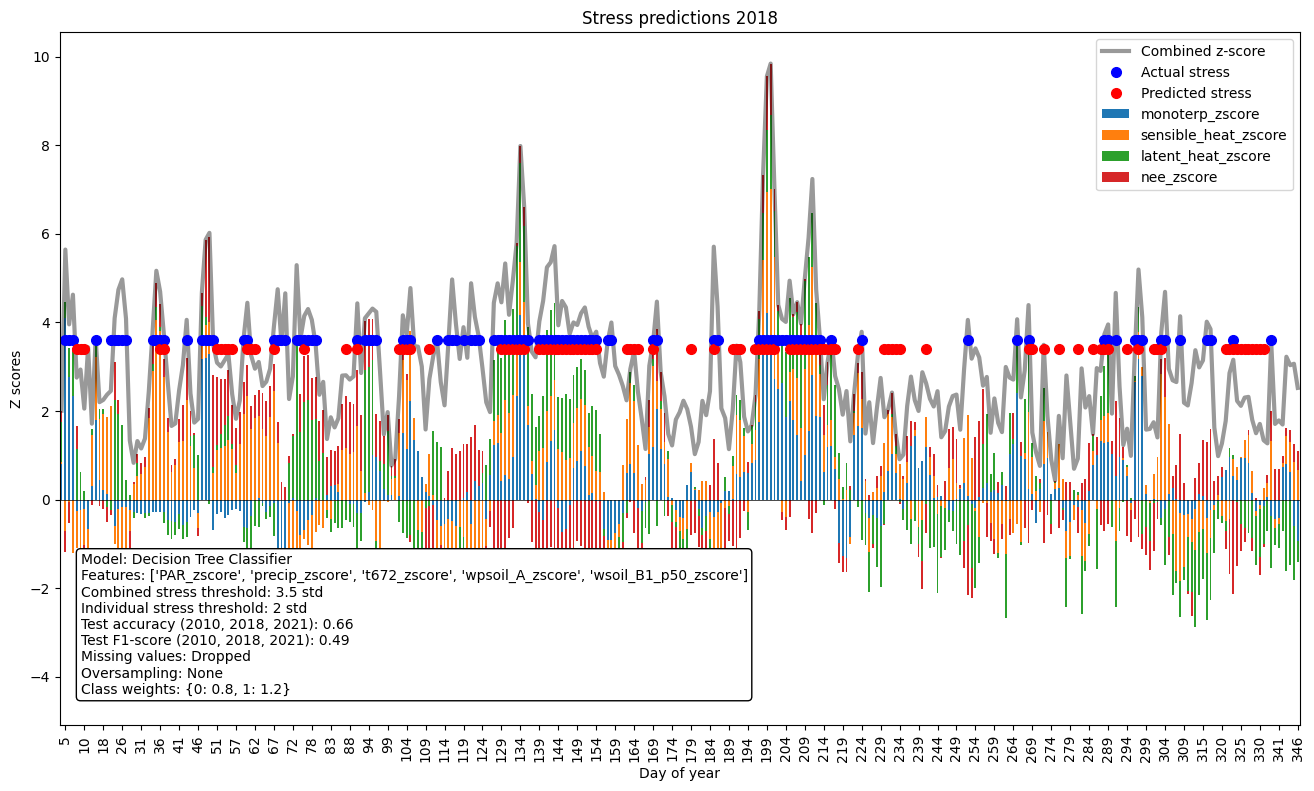

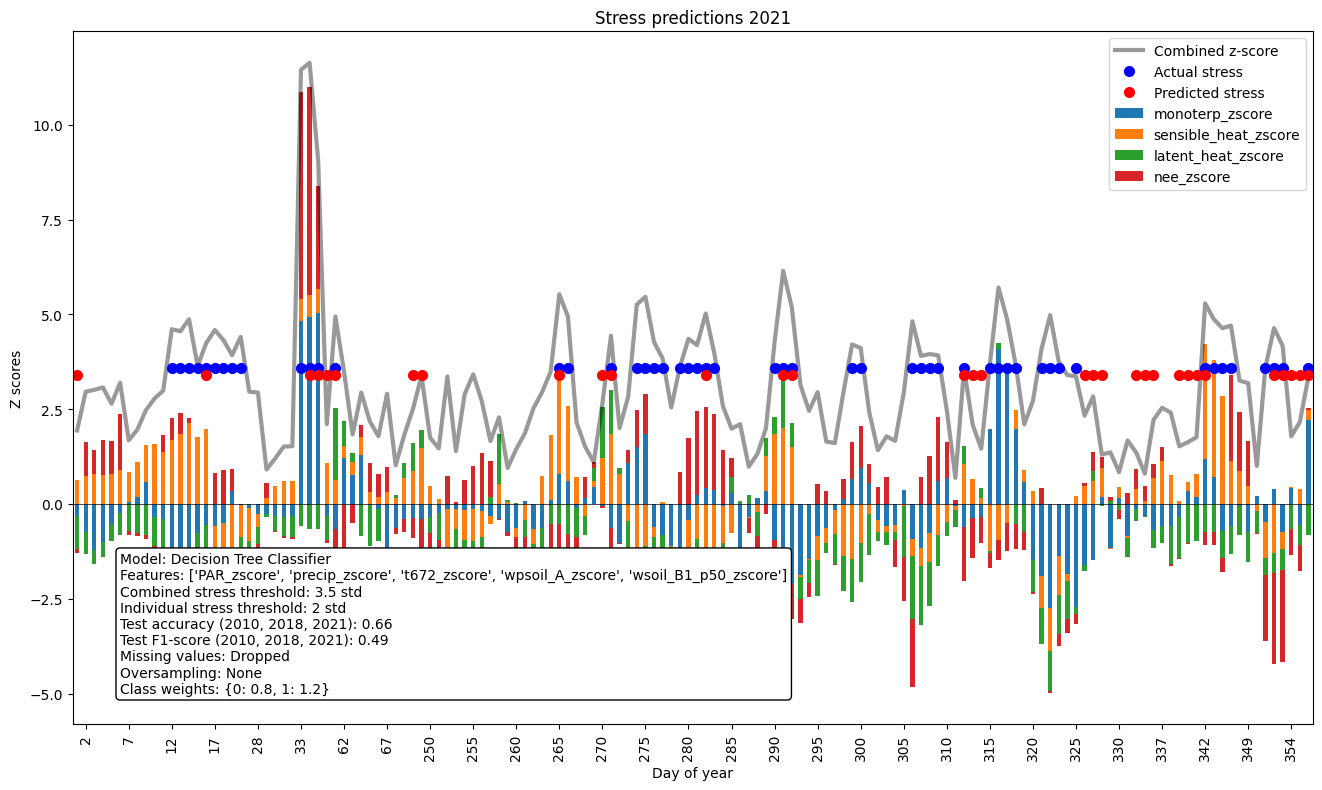

In [40]:
for year in TEST_YEARS:
    plot_year(year)